# 滴滴比赛 建模预测部分

预处理及可视化分析在其他部分

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandasql as pql
from datetime import datetime

from scipy.stats.stats import pearsonr

%matplotlib inline

In [2]:

base_dir = "G:/project/dataset/didi/season_1/training_data"

train_cluster_map_file = os.path.join(base_dir, 'cluster_map', 'cluster_map')
train_poi_file = os.path.join(base_dir, 'poi_data', 'poi_data')

train_sd_gap_file = os.path.join(base_dir, 'sd_gap.csv')


train_order_file = os.path.join(base_dir, 'order_data', 'order_data.csv')

train_traffic_file = os.path.join(base_dir, 'traffic_data', 'traffic-data.csv')

all_traffic_file = os.path.join(base_dir, 'traffic_data', 'all_traffic.csv')

small_traffic_file = os.path.join(base_dir, "traffic.csv")

# test data directory
test_base_dir = "G:/project/dataset/didi/season_1/test_set_1"
test_traffic_file = os.path.join(base_dir, 'traffic_data', 'traffic-data.csv')
test_order_file = os.path.join(test_base_dir, 'order_data', 'order-data.csv')

test_submit_file = os.path.join(test_base_dir, 'test.txt')

sd_gap_file = os.path.join(base_dir, '..', 'gap.csv')

full_index_file = os.path.join(base_dir, '..', 'fullindex.csv')

submit_file = os.path.join(test_base_dir, 'submit.csv')
result_file = os.path.join(test_base_dir, 'result.csv')

# 全体供求情况数据

区域 日期 时间片 需求 供应 缺口 星期（0-6对应周一到周天）

In [3]:
all_sd_df = pd.read_csv(sd_gap_file, dtype = {'id': np.int16, 'TimePiece': np.int16, 'demand': np.int32, 
                                                'supply': np.int32, 'gap': np.int32, 'week': np.int8})

In [15]:
all_sd_df[:5]

,id,Date,TimePiece,demand,supply,gap,week
0,1,2016-01-01,1,187,178,9,4
1,1,2016-01-01,2,198,191,7,4
2,1,2016-01-01,3,192,182,10,4
3,1,2016-01-01,4,172,167,5,4
4,1,2016-01-01,5,153,152,1,4


# 完整的索引

66个区域 * 21（21+5）天 * 144 个时间片， 完整数据要这样

有完整的， 才知道缺了哪些值， 才能填充—— 我目前想到的办法， 个人觉得比 在原dataframe 上一行行地添加数据来得快。

In [4]:
full_df = pd.read_csv(full_index_file, dtype = {'id': np.int16, 'TimePiece': np.int16})
print len(full_df)

247104


## 与已有供需数据合并

就会出现缺值位置 NaN

In [5]:
full_data = full_df.merge(all_sd_df, on=['id', 'Date', 'TimePiece'], how='left')
full_data[:3]

,id,Date,TimePiece,demand,supply,gap,week
0,1,2016-01-01,1,187,178,9,4
1,1,2016-01-01,2,198,191,7,4
2,1,2016-01-01,3,192,182,10,4


In [12]:
# 区域， 日期， 时间片三列都是 247104 行，  另外 四列有缺值。

full_data.describe()

,id,TimePiece,demand,supply,gap,week
count,247104.00000,247104.000000,171415.000000,171415.000000,171415.000000,171415.000000
mean,33.50000,72.500000,53.079363,43.596908,9.482455,3.046933
std,19.05041,41.568301,113.876910,82.040953,50.229963,1.994379
min,1.00000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,17.00000,36.750000,4.000000,3.000000,0.000000,1.000000
50%,33.50000,72.500000,12.000000,10.000000,1.000000,3.000000
75%,50.00000,108.250000,48.000000,42.000000,4.000000,5.000000
max,66.00000,144.000000,4362.000000,1084.000000,3872.000000,6.000000


## 空缺值 进行 插值 补充

针对 

1. 需求 demand
2. 供应 supply

进行插值

插值方法应该有：

1. 缺失值 前后时间片的线性插值
2. 缺失值时间片 在历史其他日期 该时间片的平均值， 或同一星期的平均值 等

仅使用了第1条， 第2条未实现

In [6]:
temp = full_data.loc[:, ['id', 'Date', 'TimePiece', 'demand', 'supply']]

In [7]:
temp.demand = temp.demand.interpolate()
temp.supply = temp.supply.interpolate()

In [8]:
temp['week'] = pd.Series([datetime.strptime(e, "%Y-%m-%d").weekday() for e in temp.Date])

In [19]:
temp.describe()

,id,TimePiece,demand,supply,week
count,247104.00000,247104.000000,247104.000000,247104.000000,247104.000000
mean,33.50000,72.500000,46.220982,37.766022,3.153846
std,19.05041,41.568301,106.971241,77.546145,1.974696
min,1.00000,1.000000,1.000000,0.000000,0.000000
25%,17.00000,36.750000,2.000000,2.000000,1.000000
50%,33.50000,72.500000,8.804952,7.000000,3.000000
75%,50.00000,108.250000,37.000000,32.000000,5.000000
max,66.00000,144.000000,4362.000000,1084.000000,6.000000


## 缺失值补充后效果

### 按星期几分组， 查看同一组下， 各日期 的平均时间线

22 24 26 28 30 是待预测的日期， 缺失值使用插值补全

20号缺失若干时间片

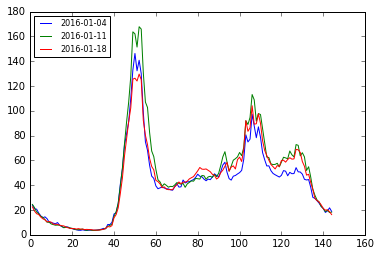

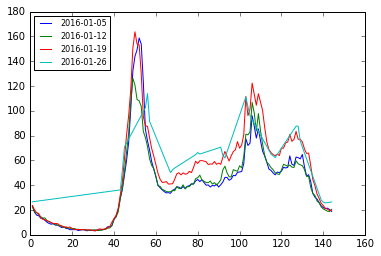

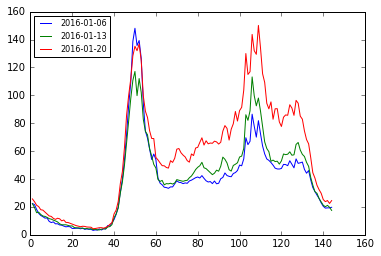

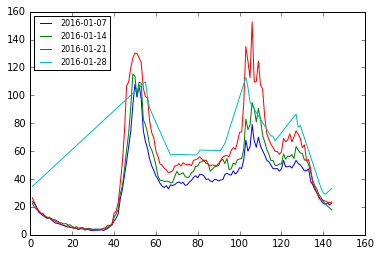

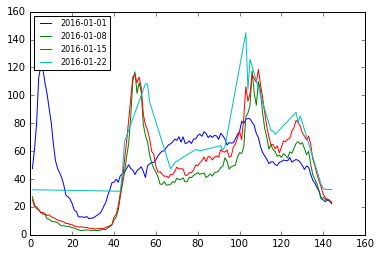

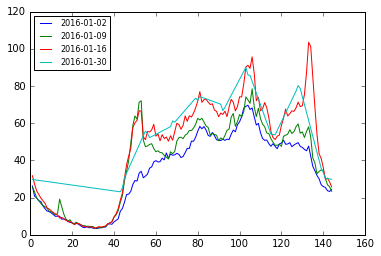

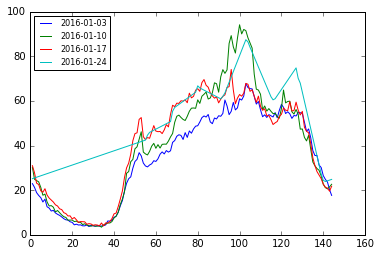

In [10]:
for week, wgr in temp.groupby('week'):
    plt.figure()
    for date, dgr in wgr.groupby('Date'):
        plt.plot(dgr.groupby('TimePiece').demand.mean(), label=str(date))
    plt.legend(loc=2,prop={'size':8})

# 过滤 元旦假期的 1号和2号

其实感觉上， 3-7号也不是特别好， 观察 这几天下班高峰期几乎没有 供需缺口

In [11]:
data = all_sd_df[all_sd_df.Date > '2016-01-02']
data[:3]

,id,Date,TimePiece,demand,supply,gap,week
288,1,2016-01-03,1,70,68,2,6
289,1,2016-01-03,2,46,44,2,6
290,1,2016-01-03,3,65,61,4,6


# 按星期、 时间片和区域分组， 求平均

因为目标是

区域， 日期-时间片， 缺口gap

使用同一星期的其他日期的平均值

In [12]:
groupData = data.groupby(['week', 'TimePiece', 'id']).mean()
group_df = groupData.reset_index()

In [14]:
group_df.describe()

,week,TimePiece,id,demand,supply,gap
count,59638.000000,59638.000000,59638.000000,59638.000000,59638.000000,59638.000000
mean,2.995557,76.712465,32.566468,48.414013,40.082685,8.331328
std,2.004689,40.282667,18.805854,104.573770,78.953319,37.077490
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,1.000000,45.000000,17.000000,3.000000,2.333333,0.333333
50%,3.000000,78.000000,32.000000,9.666667,8.333333,1.000000
75%,5.000000,111.000000,48.000000,39.666667,34.000000,3.333333
max,6.000000,144.000000,66.000000,1470.666667,766.000000,963.000000


# 提交文件的 indexfile

66个区域 * 5(22,24,26,28,30)天 * 每天若干个时间片

In [15]:
submit_df = pd.read_csv(submit_file, dtype={'id': np.int16, 'TimePiece': np.int16, 'week': np.int8})
len(submit_df)

2838

In [16]:
result = submit_df.merge(group_df, on = ['week', 'TimePiece', 'id'], how='left')
result['DateT'] = result.Date + '-' + result.TimePiece.map(str)
result_df = result.loc[:, ['id', 'DateT', 'gap']]

In [17]:
result.describe()

,id,TimePiece,week,demand,supply,gap
count,2838.000000,2838.000000,2838.000000,2752.000000,2752.000000,2752.000000
mean,33.500000,96.232558,3.767442,58.053900,49.029857,9.024043
std,19.053729,29.880071,1.723432,114.164580,86.937135,40.503947
min,1.000000,46.000000,1.000000,1.000000,0.000000,0.000000
25%,17.000000,70.000000,3.000000,4.000000,3.250000,0.333333
50%,33.500000,94.000000,4.000000,12.666667,11.333333,1.000000
75%,50.000000,118.000000,5.000000,58.416667,54.000000,3.666667
max,66.000000,142.000000,6.000000,1413.500000,726.500000,903.500000


## 发现bug， 有缺失值

In [19]:
resultnull = result[result.gap.isnull()]
resultnull[:4]

,id,Date,TimePiece,week,demand,supply,gap,DateT
391,10,2016-01-22,94,4,NaN,NaN,NaN,2016-01-22-94
403,10,2016-01-24,142,6,NaN,NaN,NaN,2016-01-24-142
412,10,2016-01-26,142,1,NaN,NaN,NaN,2016-01-26-142
429,10,2016-01-30,142,5,NaN,NaN,NaN,2016-01-30-142


In [20]:
resultnull.describe()

,id,TimePiece,week,demand,supply,gap
count,86.000000,86.000000,86.000000,0,0,0
mean,43.279070,108.790698,4.046512,NaN,NaN,NaN
std,21.383694,33.522992,1.600786,NaN,NaN,NaN
min,10.000000,46.000000,1.000000,NaN,NaN,NaN
25%,15.000000,82.000000,3.250000,NaN,NaN,NaN
50%,52.000000,118.000000,4.000000,NaN,NaN,NaN
75%,62.000000,142.000000,5.000000,NaN,NaN,NaN
max,65.000000,142.000000,6.000000,NaN,NaN,NaN


## 预测供需之差 和 预测缺口 似乎真没区别

In [34]:
sum((result.demand - result.supply - result.gap).abs() > 0.01)

0

# 22到30号目标值

但只有几个时间片的值 ， 没有和其他时间片的合并。

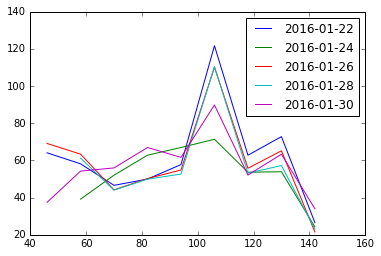

In [25]:
#for week, wgr in result.groupby('week'):
for date, dgr in result.groupby('Date'):
    plt.plot(dgr.groupby('TimePiece').demand.mean(), label=str(date))
plt.legend()

## 从日期时间片df处理csv文件

In [2]:
def resultCsv(result):
    result['DateT'] = result.Date + '-' + result.TimePiece.map(str)
    result_df = result.loc[:, ['id', 'DateT', 'gap']]
    result_df.to_csv(result_file, index=False, header=False)

In [ ]:
# resultCsv(result_df)

# 重新读取提交文件， 处理小数的gap

In [21]:
result_df = pd.read_csv(result_file, dtype={'id': np.int16}, names = ['id','DateT', 'gap'])

In [22]:
result_df.describe()

,id,gap
count,2838.000000,2838.000000
mean,33.500000,9.875617
std,19.053729,45.079310
min,1.000000,1.000000
25%,17.000000,1.000000
50%,33.500000,1.000000
75%,50.000000,3.000000
max,66.000000,953.000000


In [13]:
result_df[:5]

,id,DateT,gap
0,1,2016-01-22-46,4
1,1,2016-01-22-58,3
2,1,2016-01-22-70,6
3,1,2016-01-22-82,4
4,1,2016-01-22-94,4


In [12]:
result_df.gap = pd.Series([int(e) if e > 1.01 else 1 for e in result_df.gap])

In [14]:
result_df.to_csv(result_file, index=False, header=False)